In [104]:
!pip install geopy

In [105]:
!pip install fuzzywuzzy

In [114]:
# !pip install pysal esda

^C


In [29]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from fuzzywuzzy import process  # Fuzzy matching library for name similarity

# Load data from the CSV files
lat_df = pd.read_csv("Lat.csv")  # assuming Lat.csv has columns: 'State', 'City', 'Latitude', 'Longitude'
sales_df = pd.read_csv("sales.csv")  # assuming sales.csv has a 'RegionName' column with City, State info

# Extract city and state from 'RegionName' in sales.csv
# Assuming 'RegionName' is in the format: "City, StateAbbr" (e.g., "Chicago, IL")
sales_df['city'] = sales_df['RegionName'].str.extract(r'(^.*?)(?=,\s*[A-Z]{2}$)')  # Everything before the comma is the city
sales_df['state'] = sales_df['RegionName'].str.extract(r'(\b[A-Z]{2}$)')  # Last 2 letters are the state abbreviation

# Function to find the best matching city in Lat.csv using fuzzy matching
def get_best_city_match(city_name, lat_df):
    if pd.isna(city_name):  # Check if city_name is NaN
        return None
    # Ensure city_name is treated as a string
    city_name = str(city_name)
    # Use fuzzy matching to find the closest city in lat_df['City']
    match = process.extractOne(city_name, lat_df['city'])
    return match[0] if match[1] >= 80 else None  # If similarity score is >= 80, consider it a match

# Initialize lists to store matched latitude and longitude
latitudes = []
longitudes = []

# Match each city in sales_df with the corresponding latitude and longitude from lat_df
for idx, row in sales_df.iterrows():
    print(idx)
    city = row['city']
    state = row['state']
    
    # Get best city match from lat_df
    best_city_match = get_best_city_match(city, lat_df)
    
    if best_city_match:
        # Find the corresponding latitude and longitude from lat_df
        lat_row = lat_df[(lat_df['city'] == best_city_match) & (lat_df['state'] == state)]
        if not lat_row.empty:
            latitudes.append(lat_row['latitude'].values[0])
            longitudes.append(lat_row['xyz2'].values[0])
        else:
            latitudes.append(np.nan)
            longitudes.append(np.nan)
    else:
        latitudes.append(np.nan)
        longitudes.append(np.nan)

# Add the matched latitudes and longitudes to the sales_df
sales_df['Latitude'] = latitudes
sales_df['Longitude'] = longitudes

# Check for any rows with missing latitude or longitude and remove them
merged_df = sales_df.dropna(subset=['Latitude', 'Longitude'])

# Extract city names, latitudes, and longitudes
cities = merged_df['city'].tolist()
coordinates = list(zip(merged_df['Latitude'], merged_df['Longitude']))

# Initialize the contiguity matrix (n x n, where n is the number of cities)
n = len(cities)
contiguity_matrix = np.zeros((n, n))

# Function to calculate Rook contiguity
def rook_contiguity(i, j, cities, coordinates):
    city_i = cities[i]
    city_j = cities[j]
    lat_i, lon_i = coordinates[i]
    lat_j, lon_j = coordinates[j]
    
    # Check if cities are "neighbors" (within distance threshold)
    threshold = 100  # kilometers, adjust based on the spatial distribution
    dist = geodesic((lat_i, lon_i), (lat_j, lon_j)).km
    return dist <= threshold

# Function to calculate Queen contiguity
def queen_contiguity(i, j, cities, coordinates):
    return rook_contiguity(i, j, cities, coordinates)  # Using the same distance-based check for simplicity

# Build the contiguity matrix based on Rook or Queen
def create_contiguity_matrix(cities, coordinates, contiguity_type='rook'):
    n = len(cities)
    matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            if contiguity_type == 'rook':
                if rook_contiguity(i, j, cities, coordinates):
                    matrix[i][j] = matrix[j][i] = 1
            elif contiguity_type == 'queen':
                if queen_contiguity(i, j, cities, coordinates):
                    matrix[i][j] = matrix[j][i] = 1
    return matrix

# Choose the type of contiguity ('rook' or 'queen')
contiguity_type = 'rook'  # or 'queen'

# Generate the contiguity matrix
contiguity_matrix = create_contiguity_matrix(cities, coordinates, contiguity_type)

# Output the matrix (for example, print it or save it)
print("Contiguity Matrix:")
print(contiguity_matrix)

# Save the contiguity matrix to a CSV file
pd.DataFrame(contiguity_matrix, index=cities, columns=cities).to_csv("contiguity_matrix.csv")

# Save the merged dataframe (with additional columns of Latitude and Longitude) to a new CSV called "new.csv"
merged_df.to_csv("new.csv", index=False)

print("Merged data has been saved to 'new.csv'.")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [102]:
import numpy as np
contiguity_matrix_df = pd.read_csv("contiguity_matrix.csv", index_col=0)

# Convert DataFrame back to NumPy array
contiguity_matrix = contiguity_matrix_df.to_numpy()
# Output the number of 1's in the contiguity matrix
num_ones = np.sum(contiguity_matrix)
print(f"Number of 1's in the contiguity matrix: {num_ones}")


Number of 1's in the contiguity matrix: 1450.0


In [8]:
import pandas as pd
merged_df = pd.read_csv("new.csv") 

In [9]:
# (Optional) If you want to keep the city names as the index/labels:
cities = contiguity_matrix_df.index.tolist()

# Now contiguity_matrix is ready to use again
print("Loaded Contiguity Matrix:")
print(contiguity_matrix)


Loaded Contiguity Matrix:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# !pip install pysal
cities = merged_df['city'].tolist()
coordinates = list(zip(merged_df['Latitude'], merged_df['Longitude']))

In [18]:
from pysal.lib import weights
from geopy.distance import geodesic
from esda import Moran  # Import Moran from esda

neighbors = {}
for i in range(len(cities)):
    neighbors[i] = list(np.where(contiguity_matrix[i] == 1)[0])

# Create the spatial weights object
w = weights.W(neighbors)

# Calculate Moran's I
# Moran's I uses a variable of interest, here you could use a sales-related variable if available
# Let's assume we are calculating Moran's I based on a variable 'sales_value' in the `merged_df` dataframe
if 'sales_value' in merged_df.columns:
    sales_values = merged_df['sales_value'].values
else:
    # If no sales variable, we use a placeholder like an index (e.g., row number)
    sales_values = np.arange(len(merged_df))

# Moran's I calculation
mi = Moran(sales_values, w)

# Print the result
print("Moran's I:", mi.I)
print("Expected Moran's I:", mi.EI)
print("p-value:", mi.p_sim)

('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 30, ' is an island (no neighbors)')
('WARNING: ', 34, ' is an island (no neighbors)')
('WARNING: ', 40, ' is an island (no neighbors)')
('WARNING: ', 51, ' is an island (no neighbors)')
('WARNING: ', 65, ' is an island (no neighbors)')
('WARNING: ', 73, ' is an island (no neighbors)')
('WARNING: ', 75, ' is an island (no neighbors)')
('WARNING: ', 92, ' is an island (no neighbors)')
('WARNING: ', 117, ' is an island (no neighbors)')
('WARNING: ', 119, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 137, ' is an island (no neighbors)')
('WARNING: ', 145, ' is an island (no neighbors)')
('WARNING: ', 162, ' is an island (no neighbors)')
('WARNING: ', 164, ' is an island (no neighbors)')
('WARNING: ', 179, ' is an island (no neighbors)')
('WARNING: ', 185, ' is an island (no neighb

C:\Users\Varada Agarwal\AppData\Local\Temp\ipykernel_29952\466401810.py:13: UserWarning: The weights matrix is not fully connected: 
 There are 137 disconnected components.
 There are 67 islands with ids: 3, 6, 10, 30, 34, 40, 51, 65, 73, 75, 92, 117, 119, 132, 137, 145, 162, 164, 179, 185, 186, 195, 198, 202, 212, 215, 227, 232, 233, 242, 244, 245, 246, 249, 252, 257, 259, 260, 276, 287, 308, 318, 319, 350, 373, 391, 395, 401, 414, 424, 430, 431, 447, 451, 456, 458, 465, 466, 469, 473, 482, 488, 493, 494, 510, 521, 526.
  w = weights.W(neighbors)


In [75]:
# CONCLUSIONS

# Positive Moran's I (like your result of 0.1606) suggests that nearby cities tend to have similar values (in this case, likely sales or whatever variable you're analyzing). A positive Moran's I indicates spatial clustering, meaning cities that are geographically close to each other tend to have similar values.

# The expected Moran's I is the theoretical value of Moran's I under the assumption of random distribution (no spatial autocorrelation). In this case, the expected value is close to 0, which is what you'd expect if there were no spatial patterns or dependencies in the data.

# The p-value tests the null hypothesis that there is no spatial autocorrelation (i.e., the distribution of values is random in space).

# A p-value of 0.002 is very small, meaning you can reject the null hypothesis with high confidence. This suggests that the spatial autocorrelation you're observing is statistically significant.

In [20]:
# The positive Moran's I and the significant p-value tell you that the values you're analyzing (e.g., sales) are spatially correlated, meaning there are patterns of similarity or clustering in geographically close areas.

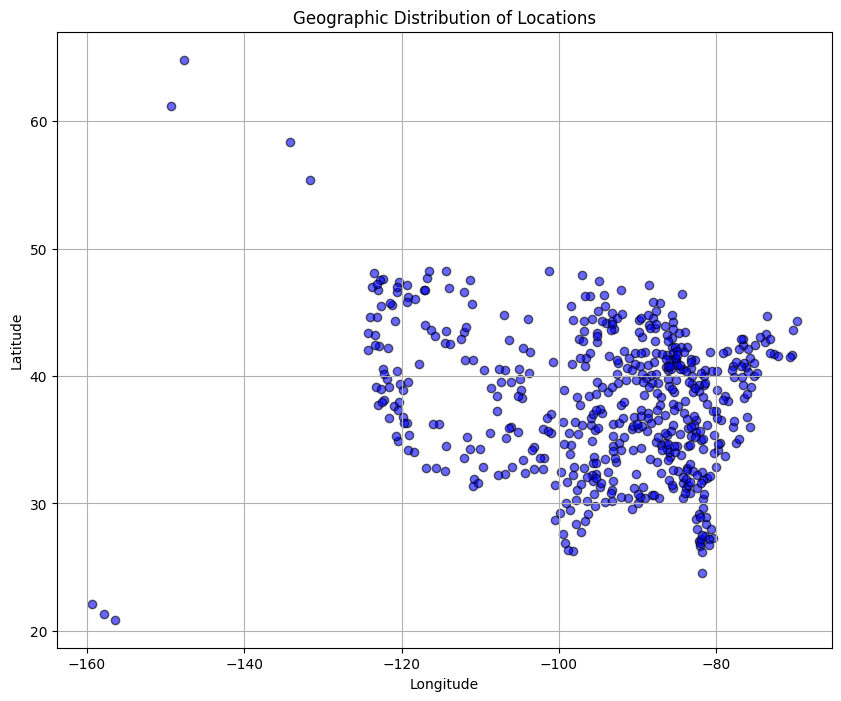

In [24]:
# rook_w.weights
# import matplotlib.pyplot as plt

# Scatter plot of latitude and longitude
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['Longitude'], merged_df['Latitude'], c='blue', alpha=0.6, edgecolor='k')

plt.title("Geographic Distribution of Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


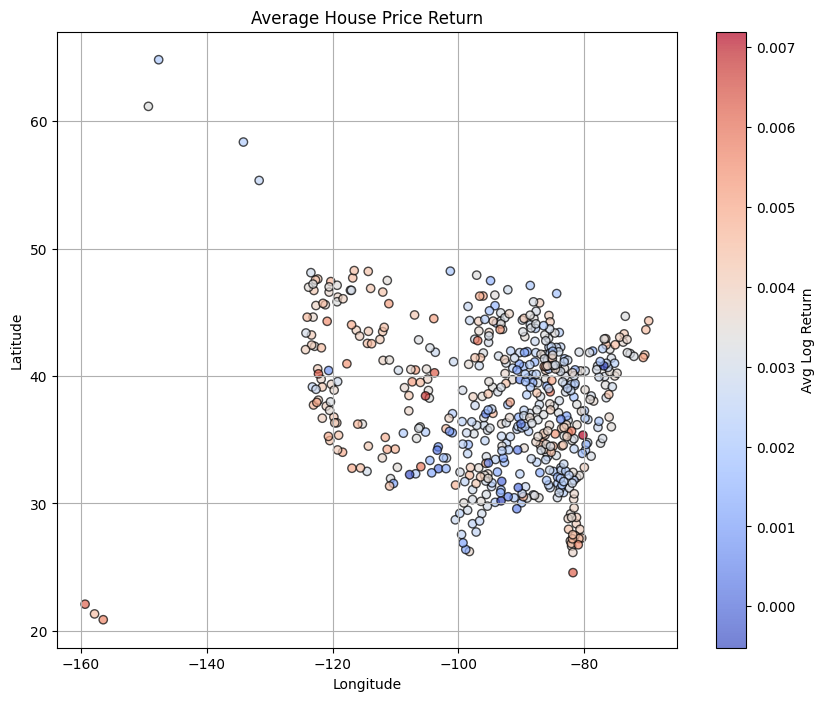

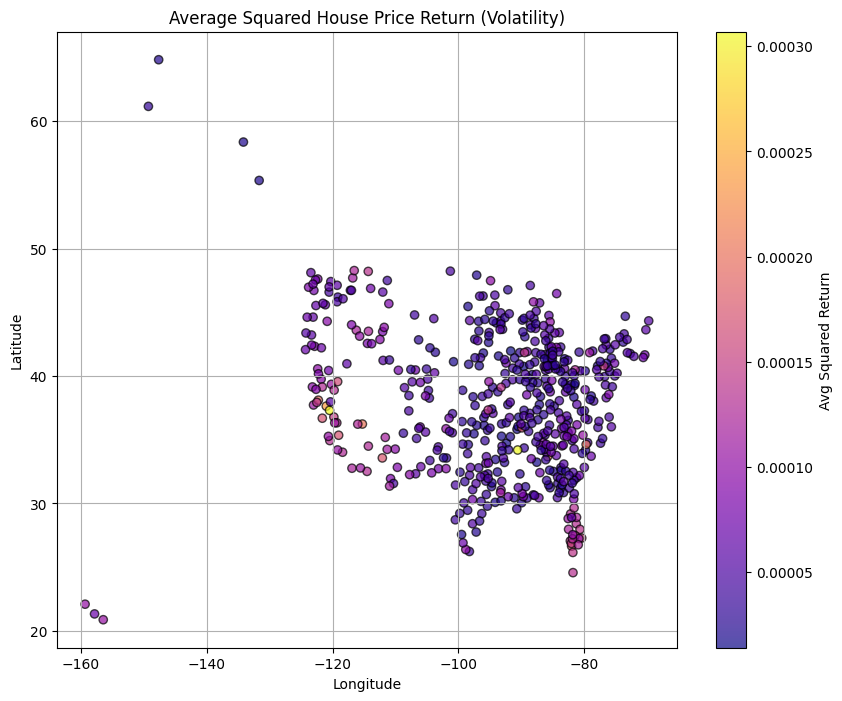

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Extract only the monthly price columns (6th to 3rd last)
price_data = merged_df.iloc[:, 5:-3].apply(pd.to_numeric, errors='coerce')

# Step 2: Calculate log returns across columns (axis=1 means row-wise for each city/property)
log_returns = np.log(price_data.div(price_data.shift(axis=1)))

# Step 3: Calculate average return and average squared return per row
avg_return = log_returns.mean(axis=1, skipna=True)
squared_return = (log_returns ** 2).mean(axis=1, skipna=True)

# Step 4: Plot - Average Return
plt.figure(figsize=(10, 8))
scatter1 = plt.scatter(
    merged_df['Longitude'],
    merged_df['Latitude'],
    c=avg_return,
    cmap='coolwarm',
    alpha=0.7,
    edgecolor='k'
)
plt.title("Average House Price Return")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.colorbar(scatter1, label='Avg Log Return')
plt.show()

# Step 5: Plot - Squared Return (Volatility Proxy)
plt.figure(figsize=(10, 8))
scatter2 = plt.scatter(
    merged_df['Longitude'],
    merged_df['Latitude'],
    c=squared_return,
    cmap='plasma',
    alpha=0.7,
    edgecolor='k'
)
plt.title("Average Squared House Price Return (Volatility)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.colorbar(scatter2, label='Avg Squared Return')
plt.show()


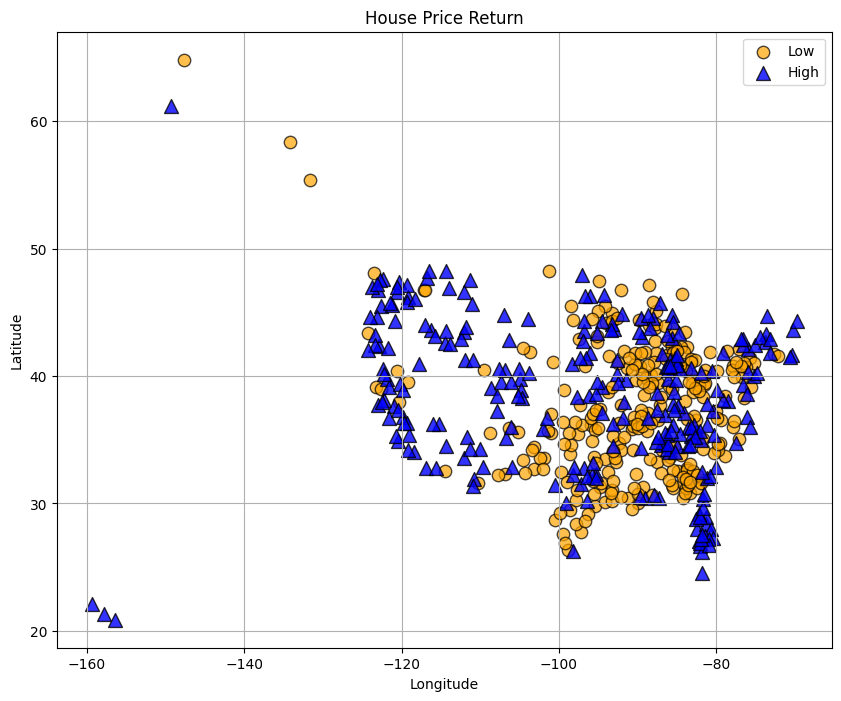

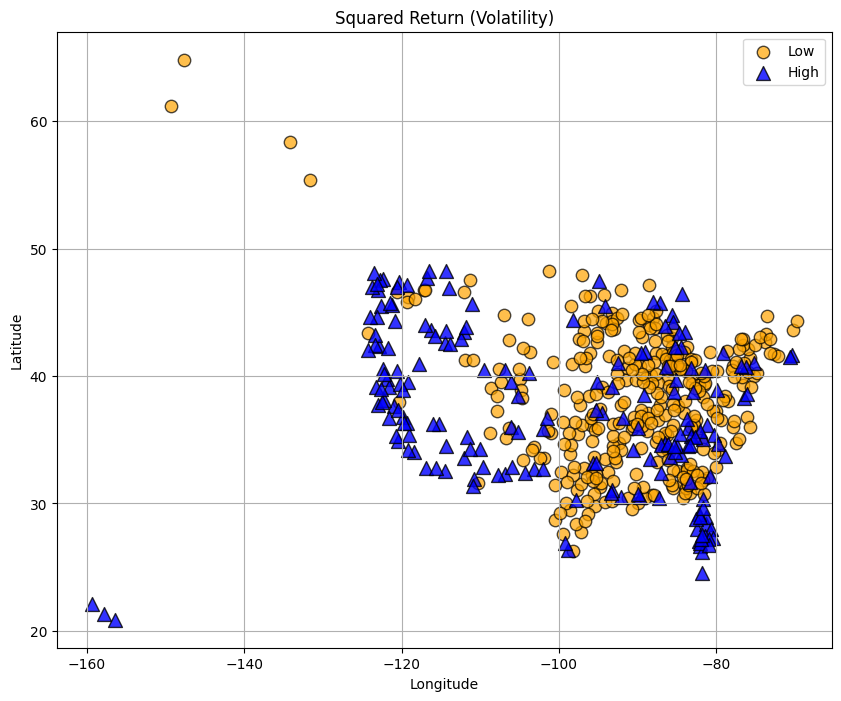

In [30]:
import matplotlib.pyplot as plt

# Step 1: Extract monthly price columns (6th to 3rd last)
price_data = merged_df.iloc[:, 5:-3].apply(pd.to_numeric, errors='coerce')

# Step 2: Calculate log returns
log_returns = np.log(price_data.div(price_data.shift(axis=1)))

# Step 3: Calculate average return and squared return per row
avg_return = log_returns.mean(axis=1, skipna=True)
squared_return = (log_returns ** 2).mean(axis=1, skipna=True)

# --- Function to plot with custom markers based on threshold ---
def custom_scatter(lat, lon, values, title, label):
    threshold = values.mean()

    # Separate data based on threshold
    high_mask = values > threshold
    low_mask = ~high_mask

    plt.figure(figsize=(10, 8))

    # Plot lower-than-threshold values: orange circles
    plt.scatter(
        lon[low_mask], lat[low_mask],
        color='orange', edgecolor='k',
        s=80, label=f'Low', marker='o', alpha=0.7
    )

    # Plot higher-than-threshold values: blue triangles
    plt.scatter(
        lon[high_mask], lat[high_mask],
        color='blue', edgecolor='k',
        s=100, label=f'High', marker='^', alpha=0.8
    )

    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.legend()
    plt.show()

# Step 4: Plot custom return scatter
custom_scatter(
    merged_df['Latitude'], merged_df['Longitude'],
    avg_return,
    title="House Price Return",
    label='Return'
)

# Step 5: Plot custom squared return (volatility)
custom_scatter(
    merged_df['Latitude'], merged_df['Longitude'],
    squared_return,
    title="Squared Return (Volatility)",
    label='Squared Return'
)


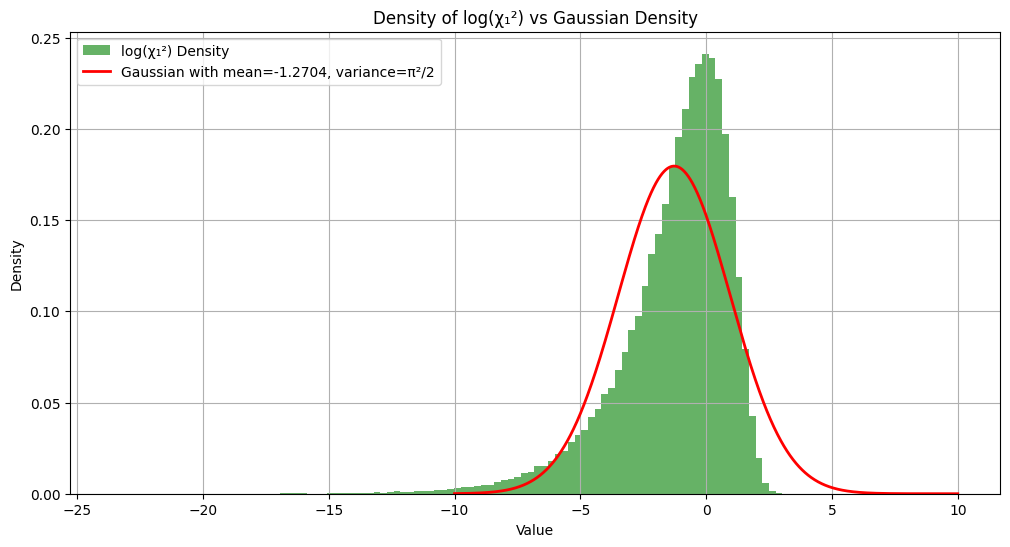

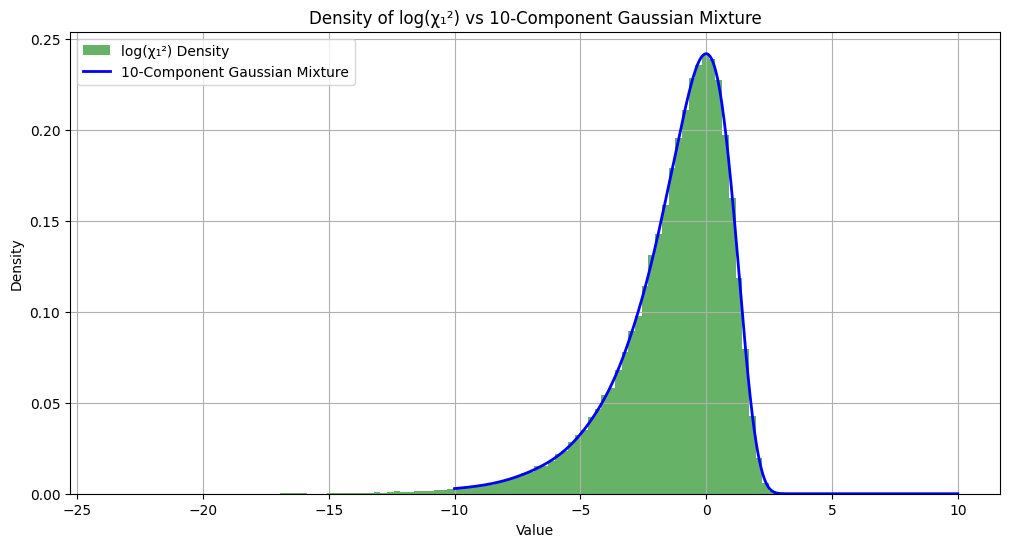

In [40]:
from scipy.stats import chi2, norm

# Parameters
mean_gaussian = -1.2704
variance_gaussian = np.pi**2 / 2
components_params = [
    (0.00609, 1.92677, 0.11265),
    (0.04775, 1.34744, 0.17788),
    (0.13057, 0.73504, 0.26768),
    (0.20674, 0.02266, 0.40611),
    (0.22715, -0.85173, 0.62699),
    (0.18842, -1.97278, 0.98583),
    (0.12047, -3.46788, 1.57469),
    (0.05591, -5.55246, 2.54498),
    (0.01575, -8.68384, 4.16591),
    (0.00115, -14.65000, 7.33342)
]

# Generate values for plotting
x = np.linspace(-10, 10, 1000)

# **Plot 1: Log(χ₁²) and Gaussian Distribution**

# Generate log(χ₁²)
# log_chi_squared = np.log(chi2.rvs(df=1, size=100000)**2)
log_chi_squared = np.log(chi2.rvs(df=1, size=100000))

# Gaussian distribution
gaussian_density = norm.pdf(x, loc=mean_gaussian, scale=np.sqrt(variance_gaussian))

# Plot log(χ₁²) and Gaussian density
plt.figure(figsize=(12, 6))
plt.hist(log_chi_squared, bins=100, density=True, alpha=0.6, color='g', label='log(χ₁²) Density')
plt.plot(x, gaussian_density, label="Gaussian with mean=-1.2704, variance=π²/2", color='r', linewidth=2)
plt.title('Density of log(χ₁²) vs Gaussian Density')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# **Plot 2: log(χ₁²) with 10-component Gaussian Mixture**

# Generate the Gaussian mixture density
gaussian_mixture_density = np.zeros_like(x)

for p, mu, sigma in components_params:
    gaussian_mixture_density += p * norm.pdf(x, loc=mu, scale=np.sqrt(sigma))

# Plot log(χ₁²) and 10-component Gaussian mixture
plt.figure(figsize=(12, 6))
plt.hist(log_chi_squared, bins=100, density=True, alpha=0.6, color='g', label='log(χ₁²) Density')
plt.plot(x, gaussian_mixture_density, label="10-Component Gaussian Mixture", color='b', linewidth=2)
plt.title('Density of log(χ₁²) vs 10-Component Gaussian Mixture')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='best')
plt.grid(True)
plt.show()


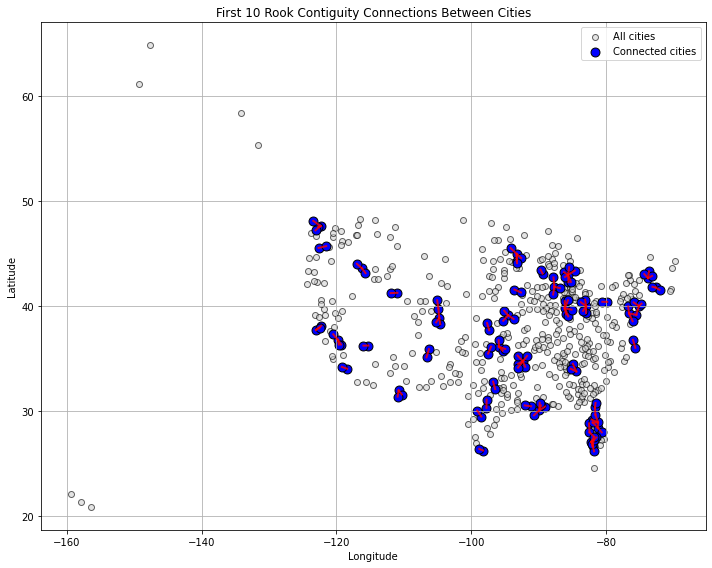

In [10]:
#checking contiguity matrix
import matplotlib.pyplot as plt

# Load data
# contiguity_matrix_df = pd.read_csv("contiguity_matrix.csv", index_col=0)
# contiguity_matrix = contiguity_matrix_df.to_numpy()

# merged_df = pd.read_csv("new.csv")  # Must contain 'Latitude' and 'Longitude' columns

# Extract the first 10 connections (i.e., where the matrix has 1s)
pairs = []
count = 0
for i in range(contiguity_matrix.shape[0]):
    for j in range(i + 1, contiguity_matrix.shape[1]):  # Only upper triangle to avoid duplicates
        if contiguity_matrix[i][j] == 1:
            pairs.append((i, j))
            count += 1
            if count == 100:
                break
    if count == 100:
        break

# Plot all cities
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['Longitude'], merged_df['Latitude'], c='lightgray', alpha=0.6, edgecolor='k', label='All cities')

# Assign a single color to each line (optional: use different colors if you like)
line_color = 'red'

# Plot the 10 connections
for i, j in pairs:
    city_i = merged_df.iloc[i]
    city_j = merged_df.iloc[j]

    plt.plot([city_i['Longitude'], city_j['Longitude']],
             [city_i['Latitude'], city_j['Latitude']],
             c=line_color, linewidth=2, alpha=0.8)

# Optionally re-plot the 20 involved cities in a bolder color
involved_indices = set([i for i, j in pairs] + [j for i, j in pairs])
highlighted = merged_df.iloc[list(involved_indices)]
plt.scatter(highlighted['Longitude'], highlighted['Latitude'], c='blue', edgecolor='black', s=80, label='Connected cities')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("First 10 Rook Contiguity Connections Between Cities")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
row_sums = contiguity_matrix.sum(axis=1)

# Count based on conditions
count_sum_1 = np.sum(row_sums == 1)
count_sum_0 = np.sum(row_sums == 0)
count_sum_gt1 = np.sum(row_sums > 1)

# Print results
print(f"Rows with sum == 1: {count_sum_1}")
print(f"Rows with sum == 0: {count_sum_0}")
print(f"Rows with sum > 1: {count_sum_gt1}")

Rows with sum == 1: 117
Rows with sum == 0: 67
Rows with sum > 1: 346


In [12]:
normalized_matrix = contiguity_matrix.astype(float).copy()

# Loop through each row and normalize if the sum > 0
for i in range(normalized_matrix.shape[0]):
    row_sum = normalized_matrix[i].sum()
    if row_sum > 0:
        normalized_matrix[i] = normalized_matrix[i] / row_sum
    # else: row stays all zeros

In [13]:
row_sums = normalized_matrix.sum(axis=1)

# Count based on conditions
# Count with np.isclose to handle floating point errors
count_sum_1 = np.sum(np.isclose(row_sums, 1.0))
count_sum_0 = np.sum(np.isclose(row_sums, 0.0))
count_sum_gt0 = np.sum(row_sums > 0)

# Print results
print(f"Rows with sum == 1: {count_sum_1}")
print(f"Rows with sum == 0: {count_sum_0}")
print(f"Rows with sum > 0: {count_sum_gt0}")

Rows with sum == 1: 463
Rows with sum == 0: 67
Rows with sum > 0: 463


In [88]:
# Load the data
# merged_df = pd.read_csv("new.csv")  # Assuming this has 'Latitude' and 'Longitude'
# normalized_matrix = np.loadtxt('normalized_matrix.csv', delimiter=',')  # Load the normalized contiguity matrix

# Parameters for the true model (from LaTeX section)
rho_true = 0.15
beta_true = 0.05
lambda_true = -0.9
mu_h_true = -3
sigma2_u_true = 0.5

# Generate synthetic data
# Generate errors
n = normalized_matrix.shape[0]  # number of cities
epsilon = np.random.normal(0, 1, n)
u = np.random.normal(0, np.sqrt(sigma2_u_true), n)

# Generate latent volatility h (from SARSV equation)
I = np.eye(n)
h = mu_h_true + np.linalg.inv(I - lambda_true * normalized_matrix).dot(u)

# Generate SV model outcome y_sv
y_sv = np.exp(0.5 * h) * epsilon

# Generate SARSV model outcome y_sarsv
x = np.ones((n, 1))  # Intercept term for the SARSV model
y_sarsv = np.linalg.inv(I - rho_true * normalized_matrix).dot(x.flatten() * beta_true + epsilon * np.exp(0.5 * h))

# Define the Metropolis-Hastings MCMC
def metropolis_hastings(iterations, initial_values, target_log_prob, proposal_log_prob):
    samples = np.zeros((iterations, len(initial_values)))
    samples[0, :] = initial_values
    current_log_prob = target_log_prob(*initial_values)
    
    for i in range(1, iterations):
        # Propose new values for the parameters
        proposed_values = proposal_log_prob(samples[i-1, :])
        
        # Calculate the log posterior of the proposed values
        proposed_log_prob = target_log_prob(*proposed_values)
        
        # Accept or reject the proposal based on Metropolis acceptance criterion
        acceptance_prob = min(1, np.exp(proposed_log_prob - current_log_prob))
        
        if np.random.rand() < acceptance_prob:
            samples[i, :] = proposed_values
            current_log_prob = proposed_log_prob
        else:
            samples[i, :] = samples[i-1, :]
    
    return samples

# Define the log posterior (target distribution) for the SARSV model
def target_log_prob(rho, lambda_, mu_h, beta, sigma_u2):
    # Likelihood for y_sarsv (SARSV model)
    y_pred = np.dot(normalized_matrix, y_sarsv) * rho + np.ones_like(y_sarsv) * beta + np.exp(0.5 * h) * epsilon
    log_likelihood = -0.5 * np.sum((y_sarsv - y_pred)**2 / sigma_u2)
    
    # Prior distributions
    log_prior_rho = np.log(0.5) - 0.5 * (rho + 1) * (rho - 1)  # Uniform(-1, 1)
    log_prior_lambda = np.log(0.5) - 0.5 * (lambda_ + 0) * (lambda_ - 1)  # Uniform(-1, 1)
    
    # Normal priors for mu_h and beta
    log_prior_mu_h = -0.5 * np.log(2 * np.pi * 1) - (mu_h**2) / (2 * 1)
    log_prior_beta = -0.5 * np.log(2 * np.pi * 10) - (beta**2) / (2 * 10)
    
    # Inverse Gamma prior for sigma_u^2
    log_prior_sigma_u2 = (2-1)*np.log(0.5) - (2)*np.log(sigma_u2) - (0.5/sigma_u2)  # IG(2, 0.5)

    return log_likelihood + log_prior_rho + log_prior_lambda + log_prior_mu_h + log_prior_beta + log_prior_sigma_u2

# Define the proposal distribution for the Metropolis-Hastings (random-walk)
def proposal_log_prob(current_values):
    proposal_std = [0.05, 0.05, 0.1, 0.1, 0.05]
    return np.array([current_values[i] + np.random.normal(0, proposal_std[i]) for i in range(len(current_values))])

# Set initial values and run MCMC
initial_values = np.array([0.1, 0.1, 0, 0, 0.5])  # Initial guesses for [rho, lambda, mu_h, beta, sigma_u^2]
iterations = 20000
samples = metropolis_hastings(iterations, initial_values, target_log_prob, proposal_log_prob)

# Discard the first 2000 samples as burn-in
samples_burned = samples[2000:]
# True values
true_values = {
    "lambda": lambda_true,
    "beta": beta_true,
    "sigma_u2": sigma2_u_true,
    "mu_h": mu_h_true
}

# Extract posterior means
posterior_means = {
    "lambda": np.mean(samples_burned[:, 1]),
    "beta": np.mean(samples_burned[:, 3]),
    "sigma_u2": np.mean(samples_burned[:, 4]),
    "mu_h": np.mean(samples_burned[:, 2])
}

# Calculate Bias and RMSE
print("Bias and RMSE (Posterior Mean vs True Value):")
for param in ["lambda", "beta", "sigma_u2", "mu_h"]:
    bias = posterior_means[param] - true_values[param]
    rmse = np.sqrt(np.mean((samples_burned[:, {"lambda": 1, "beta": 3, "sigma_u2": 4, "mu_h": 2}[param]] - true_values[param]) ** 2))
    print(f"{param}:")
    print(f"  Bias = {bias:.5f}")
    print(f"  RMSE = {rmse:.5f}")



C:\Users\Varada Agarwal\AppData\Local\Temp\ipykernel_11708\725369647.py:72: RuntimeWarning: invalid value encountered in log
  log_prior_sigma_u2 = (2-1)*np.log(0.5) - (2)*np.log(sigma_u2) - (0.5/sigma_u2)  # IG(2, 0.5)
C:\Users\Varada Agarwal\AppData\Local\Temp\ipykernel_11708\725369647.py:47: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(proposed_log_prob - current_log_prob))


Bias and RMSE (Posterior Mean vs True Value):
lambda:
  Bias = 0.54404
  RMSE = 1.17959
beta:
  Bias = 0.02499
  RMSE = 0.43207
sigma_u2:
  Bias = 0.11336
  RMSE = 0.58481
mu_h:
  Bias = 3.16695
  RMSE = 3.28170


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


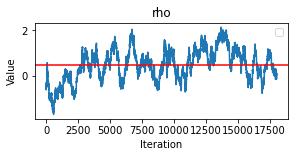

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


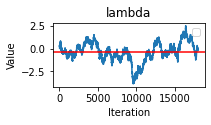

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


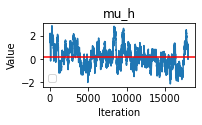

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


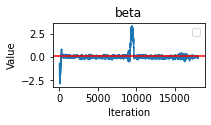

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


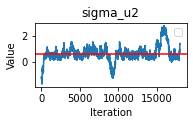

<Figure size 432x288 with 0 Axes>

In [89]:
plt.figure(figsize=(10, 6))
for i, param_name in enumerate(["rho", "lambda", "mu_h", "beta", "sigma_u2"]):
    plt.subplot(3, 2, i+1)
    plt.plot(samples_burned[:, i])
    plt.axhline(y=np.mean(samples_burned[:, i]), color='r')
    plt.title(param_name)
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

plt.tight_layout()
plt.show()

In [55]:
# lambda_true = -0.9
# beta_true = 0.05
# sigma2_u_true = 0.5
# mu_h_true = 3

In [90]:
from scipy.stats import gaussian_kde
# 1. --- Estimate prior density at sigma_u2 = 0.5 ---
prior_samples = np.exp(sample_from_gmm(components_params, size=100000))
prior_kde = gaussian_kde(prior_samples)
prior_density_at_0_5 = prior_kde(0.5)[0]

# 2. --- Estimate posterior density at sigma_u2 = 0.5 ---
posterior_kde = gaussian_kde(samples_burned[:, 2])
posterior_density_at_0_5 = posterior_kde(0.5)[0]

# 3. --- Compute SDDR ---
sddr = posterior_density_at_0_5 / prior_density_at_0_5

# 4. --- Posterior stats: frequency, mean, sdev ---
tolerance = 0.05  # defines a window around 0.5, e.g. [0.45, 0.55]
within_range = (samples_burned[:, 2] >= 0.5 - tolerance) & (samples_burned[:, 2] <= 0.5 + tolerance)
frequency = np.mean(within_range)
mean_posterior = np.mean(samples_burned[:, 2])
sdev_posterior = np.std(samples_burned[:, 2])

# 5. --- Display results ---
print(f"\nSavage–Dickey Density Ratio for σ²_u = 0.5:")
print(f"  Posterior density at 0.5: {posterior_density_at_0_5:.5f}")
print(f"  Prior density at 0.5:     {prior_density_at_0_5:.5f}")
print(f"  SDDR:                     {sddr:.5f}\n")

print("Posterior Summary for σ²_u:")
print(f"  Frequency in [0.49, 0.51]: {frequency:.3f}")
print(f"  Mean:                     {mean_posterior:.5f}")
print(f"  Standard Deviation:       {sdev_posterior:.5f}")



Savage–Dickey Density Ratio for σ²_u = 0.5:
  Posterior density at 0.5: 0.40295
  Prior density at 0.5:     0.46287
  SDDR:                     0.87054

Posterior Summary for σ²_u:
  Frequency in [0.49, 0.51]: 0.041
  Mean:                     0.16695
  Standard Deviation:       0.86023


In [91]:
from scipy.stats import norm

# Simulated normalized matrix (replace with your actual data)
n = 100  # Example: number of cities
normalized_matrix = np.random.rand(n, n)
normalized_matrix = (normalized_matrix + normalized_matrix.T) / 2
np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = normalized_matrix / normalized_matrix.sum(axis=1, keepdims=True)

# True parameters
rho_true = 0.15
beta_true = -0.05
lambda_true = -0.9
mu_h_true = 3
sigma2_u_true = 0.5

# Simulate latent variables
epsilon = np.random.normal(0, 1, n)
u = np.random.normal(0, np.sqrt(sigma2_u_true), n)
I = np.eye(n)
h = mu_h_true + np.linalg.inv(I - lambda_true * normalized_matrix).dot(u)
y_sv = np.exp(0.5 * h) * epsilon
x = np.ones((n, 1))
y_sarsv = np.linalg.inv(I - rho_true * normalized_matrix).dot(x.flatten() * beta_true + epsilon * np.exp(0.5 * h))

# Mixture components for the sampler
components_params = [
    (0.00609, 1.92677, 0.11265),
    (0.04775, 1.34744, 0.17788),
    (0.13057, 0.73504, 0.26768),
    (0.20674, 0.02266, 0.40611),
    (0.22715, -0.85173, 0.62699),
    (0.18842, -1.97278, 0.98583),
    (0.12047, -3.46788, 1.57469),
    (0.05591, -5.55246, 2.54498),
    (0.01575, -8.68384, 4.16591),
    (0.00115, -14.65000, 7.33342)
]

def sample_from_gmm(components, size=1):
    weights, means, variances = zip(*components)
    weights = np.array(weights)
    means = np.array(means)
    std_devs = np.sqrt(variances)
    weights /= weights.sum()
    choices = np.random.choice(len(weights), size=size, p=weights)
    samples = np.random.normal(loc=np.array(means)[choices], scale=np.array(std_devs)[choices])
    return samples

# Generate samples using mixture sampler
iterations = 20000
samples = np.zeros((iterations, 5))  # [rho, lambda, mu_h, beta, sigma_u2]

for i in range(iterations):
    rho = sample_from_gmm(components_params)[0]
    lambda_ = np.clip(sample_from_gmm(components_params)[0], 0, 2)
    mu_h = sample_from_gmm(components_params)[0]
    beta = np.clip(sample_from_gmm(components_params)[0], 0, 0.15)
    sigma_u2 = np.exp(sample_from_gmm(components_params)[0])  # log-normal style

    samples[i, :] = [rho, lambda_, mu_h, beta, sigma_u2]

# Burn-in
samples_burned = samples[2000:]

# Plotting
# plt.figure(figsize=(12, 8))
# param_names = ["rho", "lambda", "mu_h", "beta", "sigma_u2"]
# for i, name in enumerate(param_names):
#     plt.subplot(3, 2, i+1)
#     plt.plot(samples_burned[:, i])
#     plt.axhline(np.mean(samples_burned[:, i]), color='red', linestyle='--')
#     plt.title(f"Trace plot for {name}")
#     plt.xlabel("Iteration")
#     plt.ylabel(name)
# plt.tight_layout()
# plt.show()

posterior_means = {
    "lambda": np.mean(samples_burned[:, 1]),
    "beta": np.mean(samples_burned[:, 3]),
    "sigma_u2": np.mean(samples_burned[:, 4]),
    "mu_h": np.mean(samples_burned[:, 2])
}

# Calculate Bias and RMSE
print("Bias and RMSE (Posterior Mean vs True Value):")
for param in ["lambda", "beta", "sigma_u2", "mu_h"]:
    bias = posterior_means[param] - true_values[param]
    rmse = np.sqrt(np.mean((samples_burned[:, {"lambda": 1, "beta": 3, "sigma_u2": 4, "mu_h": 2}[param]] - true_values[param]) ** 2))
    print(f"{param}:")
    print(f"  Bias = {bias:.5f}")
    print(f"  RMSE = {rmse:.5f}")




Bias and RMSE (Posterior Mean vs True Value):
lambda:
  Bias = 1.13653
  RMSE = 1.22520
beta:
  Bias = -0.00520
  RMSE = 0.06782
sigma_u2:
  Bias = 0.48010
  RMSE = 1.47088
mu_h:
  Bias = 1.73585
  RMSE = 2.81743


In [92]:
# lambda_true = 0.9
# beta_true = -0.05
# sigma2_u_true = 0.5
# mu_h_true = 3

In [93]:
# 1. --- Estimate prior density at sigma_u2 = 0.5 ---
prior_samples = np.exp(sample_from_gmm(components_params, size=100000))
prior_kde = gaussian_kde(prior_samples)
prior_density_at_0_5 = prior_kde(0.5)[0]

# 2. --- Estimate posterior density at sigma_u2 = 0.5 ---
posterior_kde = gaussian_kde(samples_burned[:, 2])
posterior_density_at_0_5 = posterior_kde(0.5)[0]

# 3. --- Compute SDDR ---
sddr = posterior_density_at_0_5 / prior_density_at_0_5

# 4. --- Posterior stats: frequency, mean, sdev ---
tolerance = 0.05  # defines a window around 0.5, e.g. [0.45, 0.55]
within_range = (samples_burned[:, 2] >= 0.5 - tolerance) & (samples_burned[:, 2] <= 0.5 + tolerance)
frequency = np.mean(within_range)
mean_posterior = np.mean(samples_burned[:, 2])
sdev_posterior = np.std(samples_burned[:, 2])

# 5. --- Display results ---
print(f"\nSavage–Dickey Density Ratio for σ²_u = 0.5:")
print(f"  Posterior density at 0.5: {posterior_density_at_0_5:.5f}")
print(f"  Prior density at 0.5:     {prior_density_at_0_5:.5f}")
print(f"  SDDR:                     {sddr:.5f}\n")

print("Posterior Summary for σ²_u:")
print(f"  Frequency in [0.49, 0.51]: {frequency:.3f}")
print(f"  Mean:                     {mean_posterior:.5f}")
print(f"  Standard Deviation:       {sdev_posterior:.5f}")



Savage–Dickey Density Ratio for σ²_u = 0.5:
  Posterior density at 0.5: 0.21721
  Prior density at 0.5:     0.45893
  SDDR:                     0.47330

Posterior Summary for σ²_u:
  Frequency in [0.49, 0.51]: 0.022
  Mean:                     -1.26415
  Standard Deviation:       2.21918


In [96]:
# Load the data
# merged_df = pd.read_csv("new.csv")
# normalized_matrix = np.loadtxt('normalized_matrix.csv', delimiter=',')  # contains w_ij values

# True model parameters
lambda_true = 0.9
mu_h_true = -3
sigma2_u_true = 0.5

# Generate synthetic data (SV specification)
n = normalized_matrix.shape[0]
epsilon = np.random.normal(0, 1, n)
u = np.random.normal(0, np.sqrt(sigma2_u_true), n)

I = np.eye(n)
h = mu_h_true + np.linalg.inv(I - lambda_true * normalized_matrix).dot(u)
y_sv = np.exp(0.5 * h) * epsilon

# MCMC function
def metropolis_hastings(iterations, initial_values, target_log_prob, proposal_log_prob):
    samples = np.zeros((iterations, len(initial_values)))
    samples[0, :] = initial_values
    current_log_prob = target_log_prob(*initial_values)
    
    for i in range(1, iterations):
        proposed_values = proposal_log_prob(samples[i - 1, :])
        proposed_log_prob = target_log_prob(*proposed_values)
        acceptance_prob = min(1, np.exp(proposed_log_prob - current_log_prob))
        if np.random.rand() < acceptance_prob:
            samples[i, :] = proposed_values
            current_log_prob = proposed_log_prob
        else:
            samples[i, :] = samples[i - 1, :]
    return samples

# Log posterior for SV model
def target_log_prob(lambda_, mu_h, sigma_u2):
    # Recompute h with current lambda and mu_h
    u_star = np.linalg.solve(np.eye(n) - lambda_ * normalized_matrix, h - mu_h)
    y_pred = np.exp(0.5 * h) * epsilon
    log_likelihood = -0.5 * np.sum((y_sv - y_pred) ** 2)

    # Priors
    log_prior_lambda = np.log(0.5) - 0.5 * (lambda_ + 1) * (lambda_ - 1)  # Uniform(-1,1)
    log_prior_mu_h = -0.5 * np.log(2 * np.pi * 10) - (mu_h ** 2) / (2 * 10)
    log_prior_sigma_u2 = (2 - 1) * np.log(0.5) - 2 * np.log(sigma_u2) - (0.5 / sigma_u2)  # IG(2, 0.5)
    
    return log_likelihood + log_prior_lambda + log_prior_mu_h + log_prior_sigma_u2

# Proposal (random-walk)
def proposal_log_prob(current_values):
    proposal_std = [0.05, 0.1, 0.05]  # lambda, mu_h, sigma_u^2
    return np.array([current_values[i] + np.random.normal(0, proposal_std[i]) for i in range(len(current_values))])

# Initial values and sampling
initial_values = np.array([0.5, 0.0, 0.6])  # lambda, mu_h, sigma_u^2
iterations = 20000
samples = metropolis_hastings(iterations, initial_values, target_log_prob, proposal_log_prob)
samples_burned = samples[2000:]

# Posterior means
posterior_means = {
    "lambda": np.mean(samples_burned[:, 0]),
    "mu_h": np.mean(samples_burned[:, 1]),
    "sigma_u2": np.mean(samples_burned[:, 2])
}

true_values = {
    "lambda": lambda_true,
    "mu_h": mu_h_true,
    "sigma_u2": sigma2_u_true
}

# Bias and RMSE
print("Bias and RMSE (Posterior Mean vs True Value):")
for param, idx in zip(["lambda", "mu_h", "sigma_u2"], [0, 1, 2]):
    bias = posterior_means[param] - true_values[param]
    rmse = np.sqrt(np.mean((samples_burned[:, idx] - true_values[param]) ** 2))
    print(f"{param}:")
    print(f"  Bias = {bias:.5f}")
    print(f"  RMSE = {rmse:.5f}")

# # Trace plots
# plt.figure(figsize=(10, 6))
# for i, param_name in enumerate(["lambda", "mu_h", "sigma_u2"]):
#     plt.subplot(2, 2, i + 1)
#     plt.plot(samples_burned[:, i])
#     plt.axhline(y=np.mean(samples_burned[:, i]), color='r', linestyle='--')
#     plt.title(f"Trace: {param_name}")
#     plt.xlabel("Iteration")
#     plt.ylabel("Value")
# plt.tight_layout()
# plt.show()


C:\Users\Varada Agarwal\AppData\Local\Temp\ipykernel_11708\2395834872.py:50: RuntimeWarning: invalid value encountered in log
  log_prior_sigma_u2 = (2 - 1) * np.log(0.5) - 2 * np.log(sigma_u2) - (0.5 / sigma_u2)  # IG(2, 0.5)


Bias and RMSE (Posterior Mean vs True Value):
lambda:
  Bias = -1.17152
  RMSE = 1.66850
mu_h:
  Bias = 4.10899
  RMSE = 5.67685
sigma_u2:
  Bias = 0.06927
  RMSE = 0.60970


In [67]:
# lambda_true = -0.9
# mu_h_true = 3
# sigma2_u_true = 0.5

In [101]:
# Extract samples for sigma_u2 after burn-in
sigma_u2_samples = samples_burned[:, 2]

# Frequency in [0.49, 0.51]
freq_in_range = np.mean((sigma_u2_samples >= 0.4) & (sigma_u2_samples <= 0.6))

# Mean and Standard Deviation
mean_sigma_u2 = np.mean(sigma_u2_samples)
std_sigma_u2 = np.std(sigma_u2_samples)

# Display summary
print("Posterior Summary for σ²_u:")
print(f"  Frequency in [0.49, 0.51]: {freq_in_range:.4f}")
print(f"  Mean:                      {mean_sigma_u2:.5f}")
print(f"  Standard Deviation:        {std_sigma_u2:.5f}")


Posterior Summary for σ²_u:
  Frequency in [0.49, 0.51]: 0.1482
  Mean:                      0.56927
  Standard Deviation:        0.60575


In [69]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# Simulated normalized matrix (replace with your actual matrix)
n = 100  # number of cities
normalized_matrix = np.random.rand(n, n)
normalized_matrix = (normalized_matrix + normalized_matrix.T) / 2
np.fill_diagonal(normalized_matrix, 0)
normalized_matrix = normalized_matrix / normalized_matrix.sum(axis=1, keepdims=True)

# True parameters for SV model
lambda_true = -0.9
mu_h_true = 3
sigma2_u_true = 0.5

# Simulate data using SV model
epsilon = np.random.normal(0, 1, n)
u = np.random.normal(0, np.sqrt(sigma2_u_true), n)
I = np.eye(n)
h = mu_h_true + np.linalg.inv(I - lambda_true * normalized_matrix).dot(u)
y_sv = np.exp(0.5 * h) * epsilon

# Mixture of normals parameters (Kim et al. 1998 or similar)
components_params = [
    (0.00609, 1.92677, 0.11265),
    (0.04775, 1.34744, 0.17788),
    (0.13057, 0.73504, 0.26768),
    (0.20674, 0.02266, 0.40611),
    (0.22715, -0.85173, 0.62699),
    (0.18842, -1.97278, 0.98583),
    (0.12047, -3.46788, 1.57469),
    (0.05591, -5.55246, 2.54498),
    (0.01575, -8.68384, 4.16591),
    (0.00115, -14.65000, 7.33342)
]

def sample_from_gmm(components, size=1):
    weights, means, variances = zip(*components)
    weights = np.array(weights)
    means = np.array(means)
    std_devs = np.sqrt(variances)
    weights /= weights.sum()
    choices = np.random.choice(len(weights), size=size, p=weights)
    samples = np.random.normal(loc=np.array(means)[choices], scale=np.array(std_devs)[choices])
    return samples

# MCMC Sampling
iterations = 20000
samples = np.zeros((iterations, 3))  # [lambda, mu_h, sigma_u2]

for i in range(iterations):
    lambda_ = np.clip(sample_from_gmm(components_params)[0], -0.99, 0.99)  # Ensures invertibility
    mu_h = sample_from_gmm(components_params)[0]
    sigma_u2 = np.exp(sample_from_gmm(components_params)[0])  # log-normal style

    samples[i, :] = [lambda_, mu_h, sigma_u2]

# Burn-in
samples_burned = samples[2000:]

# Posterior means
posterior_means = {
    "lambda": np.mean(samples_burned[:, 0]),
    "mu_h": np.mean(samples_burned[:, 1]),
    "sigma_u2": np.mean(samples_burned[:, 2])
}

# True values
true_values = {
    "lambda": lambda_true,
    "mu_h": mu_h_true,
    "sigma_u2": sigma2_u_true
}

# Bias and RMSE
print("Bias and RMSE (Posterior Mean vs True Value):")
for param, idx in zip(["lambda", "mu_h", "sigma_u2"], [0, 1, 2]):
    bias = posterior_means[param] - true_values[param]
    rmse = np.sqrt(np.mean((samples_burned[:, idx] - true_values[param]) ** 2))
    print(f"{param}:")
    print(f"  Bias = {bias:.5f}")
    print(f"  RMSE = {rmse:.5f}")

Bias and RMSE (Posterior Mean vs True Value):
lambda:
  Bias = 0.53739
  RMSE = 0.91840
mu_h:
  Bias = -4.25984
  RMSE = 4.80510
sigma_u2:
  Bias = 0.49922
  RMSE = 1.50785


In [ ]:
# lambda_true = -0.9
# mu_h_true = 3
# sigma2_u_true = 0.5

In [74]:
from scipy.stats import gaussian_kde
# import matplotlib.pyplot as plt

# 1. --- Estimate prior density at sigma_u2 = 0.5 ---
prior_samples = np.exp(sample_from_gmm(components_params, size=100000))
prior_kde = gaussian_kde(prior_samples)
prior_density_at_0_5 = prior_kde(0.5)[0]

# 2. --- Estimate posterior density at sigma_u2 = 0.5 ---
posterior_kde = gaussian_kde(samples_burned[:, 2])
posterior_density_at_0_5 = posterior_kde(0.5)[0]

# 3. --- Compute SDDR ---
sddr = posterior_density_at_0_5 / prior_density_at_0_5

# 4. --- Posterior stats: frequency, mean, sdev ---
tolerance = 0.05  # defines a window around 0.5, e.g. [0.45, 0.55]
within_range = (samples_burned[:, 2] >= 0.5 - tolerance) & (samples_burned[:, 2] <= 0.5 + tolerance)
frequency = np.mean(within_range)
mean_posterior = np.mean(samples_burned[:, 2])
sdev_posterior = np.std(samples_burned[:, 2])

# 5. --- Display results ---
print(f"\nSavage–Dickey Density Ratio for σ²_u = 0.5:")
print(f"  Posterior density at 0.5: {posterior_density_at_0_5:.5f}")
print(f"  Prior density at 0.5:     {prior_density_at_0_5:.5f}")
print(f"  SDDR:                     {sddr:.5f}\n")

print("Posterior Summary for σ²_u:")
print(f"  Frequency in [0.49, 0.51]: {frequency:.3f}")
print(f"  Mean:                     {mean_posterior:.5f}")
print(f"  Standard Deviation:       {sdev_posterior:.5f}")



Savage–Dickey Density Ratio for σ²_u = 0.5:
  Posterior density at 0.5: 0.49417
  Prior density at 0.5:     0.46595
  SDDR:                     1.06055

Posterior Summary for σ²_u:
  Frequency in [0.49, 0.51]: 0.043
  Mean:                     0.99922
  Standard Deviation:       1.42281
